In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from xgboost import XGBClassifier, plot_importance as xg_importance
from lightgbm import LGBMClassifier, plot_importance as lgb_importance

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./creditcard.csv')

# scailing

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

In [4]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [5]:
def metrics(y_test, predict):
    acc = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    roc_score = roc_auc_score(y_test, predict)
    
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(acc, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

def get_X_y_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify = y)
    return X_train, X_test, y_train, y_test

def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)

# origin data StratifiedShuffleSplit

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset', 'total count: ',data['Class'].value_counts()[0])
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset', 'total count: ', data['Class'].value_counts()[1])

X = data.drop('Class', axis=1)
y = data['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    unique, counts = np.unique(original_ytrain, return_counts=True)
    print(unique, counts)
    unique, counts = np.unique(original_ytest, return_counts=True)
    print(unique, counts)
    
#     lr = LogisticRegression()
#     modeling(lr, original_Xtrain, original_Xtest, original_ytrain, original_ytest)

#     lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
#     modeling(lgb,  original_Xtrain, original_Xtest, original_ytrain, original_ytest)
    
    print('*' * 20)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label)
print(test_counts_label)
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset total count:  284315
Frauds 0.17 % of the dataset total count:  492
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
[0 1] [227452    393]
[0 1] [56863    99]
********************
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
[0 1] [227452    393]
[0 1] [56863    99]
********************
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
[0 1] [227452    394]
[0 1] [56863    98]
********************
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
[0 1] [227452    394]
[0 1] [56863    98]
********************
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
[0 1] [227452    394]
[0 1] [56863    98]
********************
---------------------------------------------

# Random Under Sampling

In [11]:
data = data.sample(frac=1)

fraud_df = data.loc[data['Class'] == 1]
print(fraud_df.shape[0])
non_fraud_df = data.loc[data['Class'] == 0][:fraud_df.shape[0]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=20)
new_df.head()

492


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
107700,-0.305736,-0.165944,1.279572,0.273420,0.429068,0.910150,-0.152134,-0.286731,-0.102552,-0.053086,...,-0.113904,-0.249759,-0.708377,0.012924,-0.504844,0.412629,-0.570381,0.037018,0.025284,0
256302,-0.279746,0.856906,-0.587100,1.442580,-0.661172,-0.795153,0.735726,-0.570864,0.773890,0.131934,...,0.346346,-0.377375,-0.804947,0.160077,0.567152,-0.351661,0.109458,0.536111,0.252903,0
77348,-0.307273,-0.325251,-1.271244,2.462675,-2.851395,2.324480,-1.372245,-0.948196,-3.065234,1.166927,...,0.560478,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.632800,0.250187,1
42549,0.925452,-0.511578,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,...,1.150017,2.331466,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,1
172787,1.713407,0.429352,-2.628922,2.275636,-3.745369,1.226948,-1.132966,-1.256353,-1.752420,0.281736,...,0.133106,0.870730,1.269473,-0.265494,-0.480549,0.169665,0.096081,0.070036,0.063768,1


Class
0    0.5
1    0.5
Name: count, dtype: float64


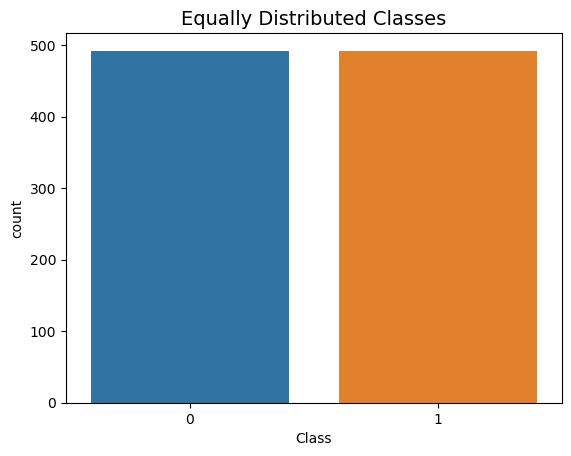

In [12]:
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x = 'Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [13]:
new_df_copy = new_df.copy()

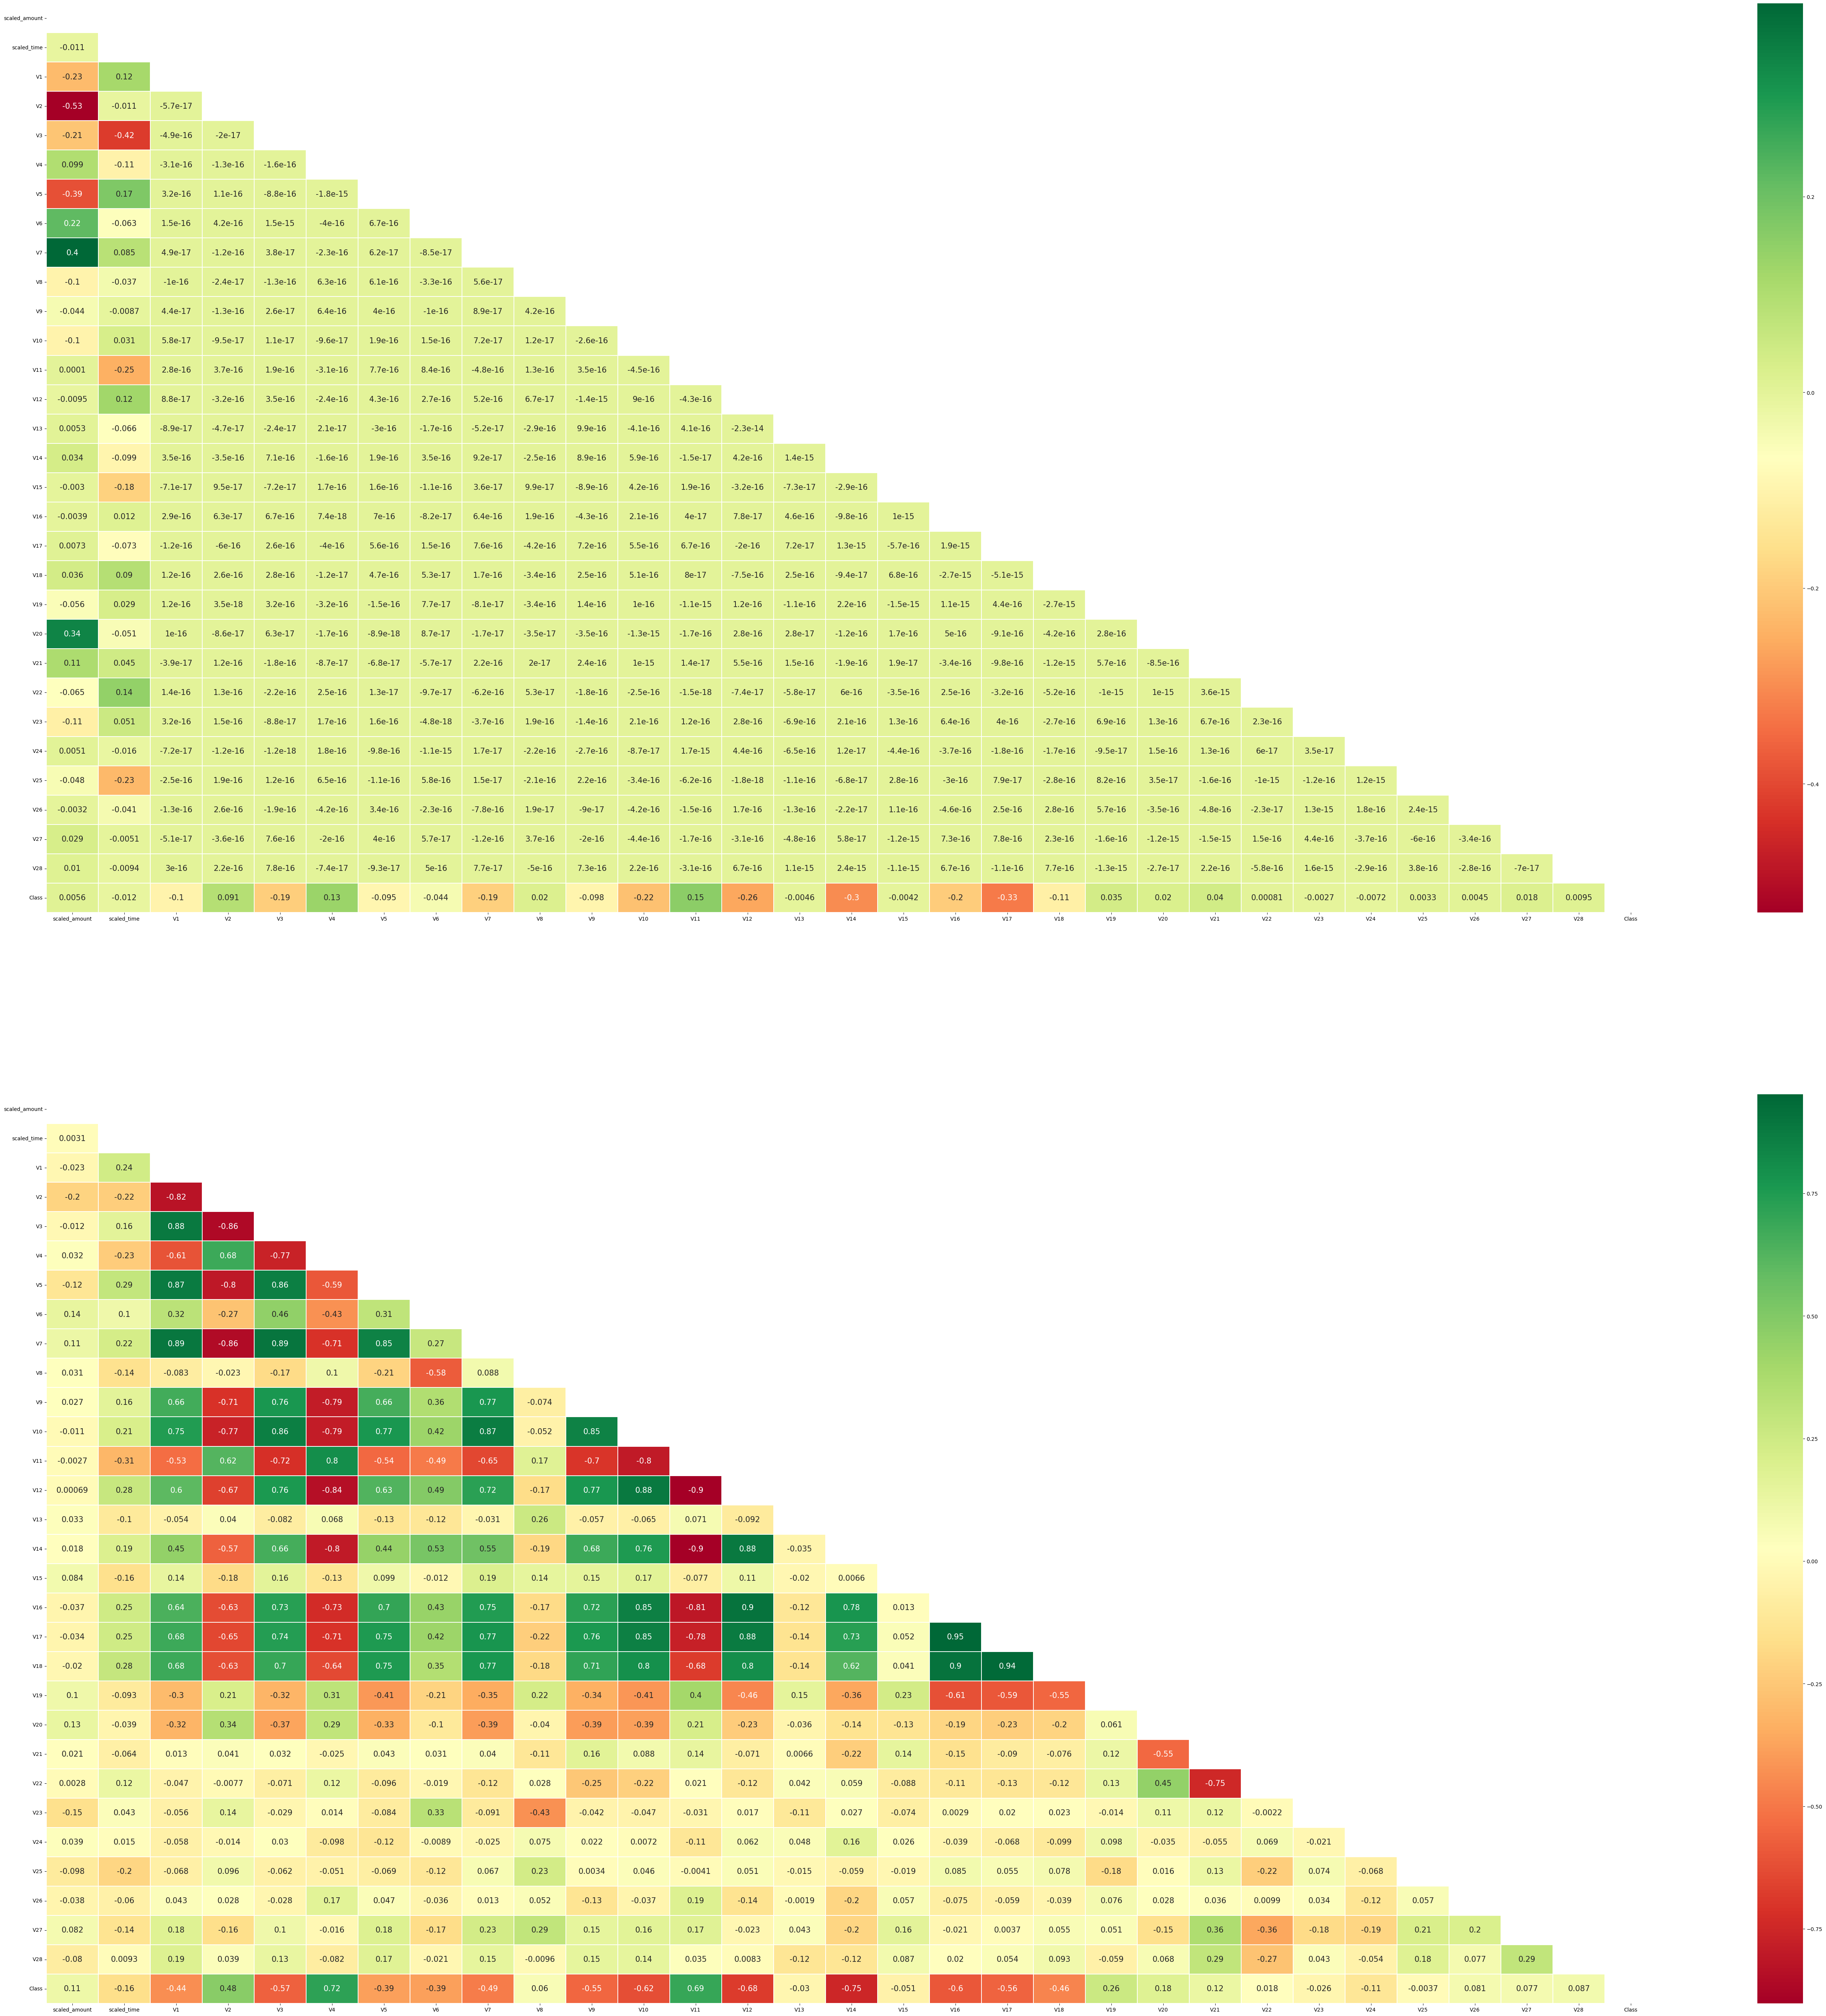

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(70,70))

mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(data.corr(), mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':15}, ax=ax1)

mask = np.zeros_like(new_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(new_df.corr(), mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':15}, ax=ax2)

plt.show()

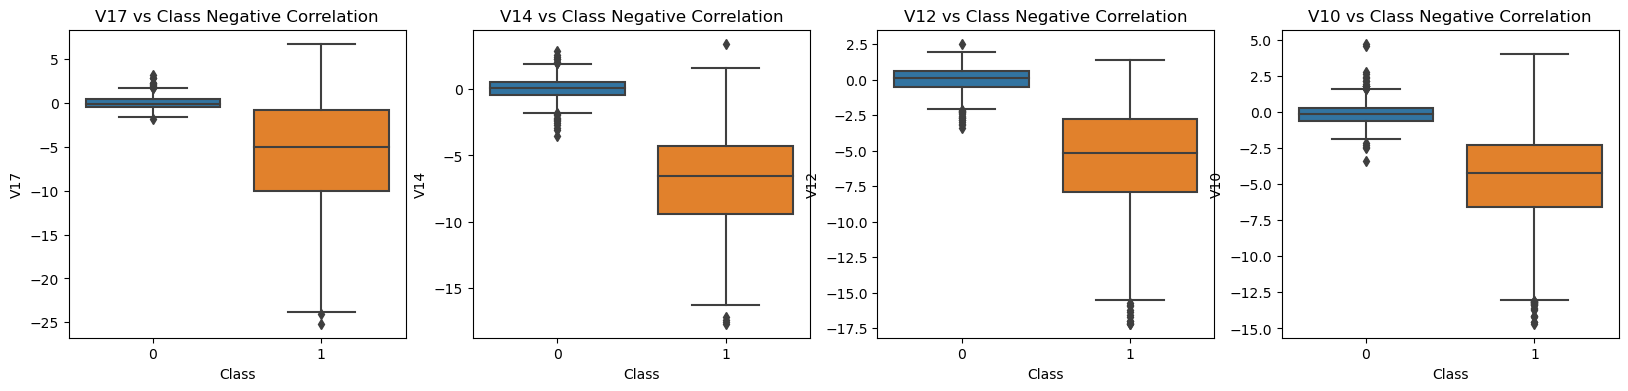

In [21]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df,  ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df,ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df,  ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

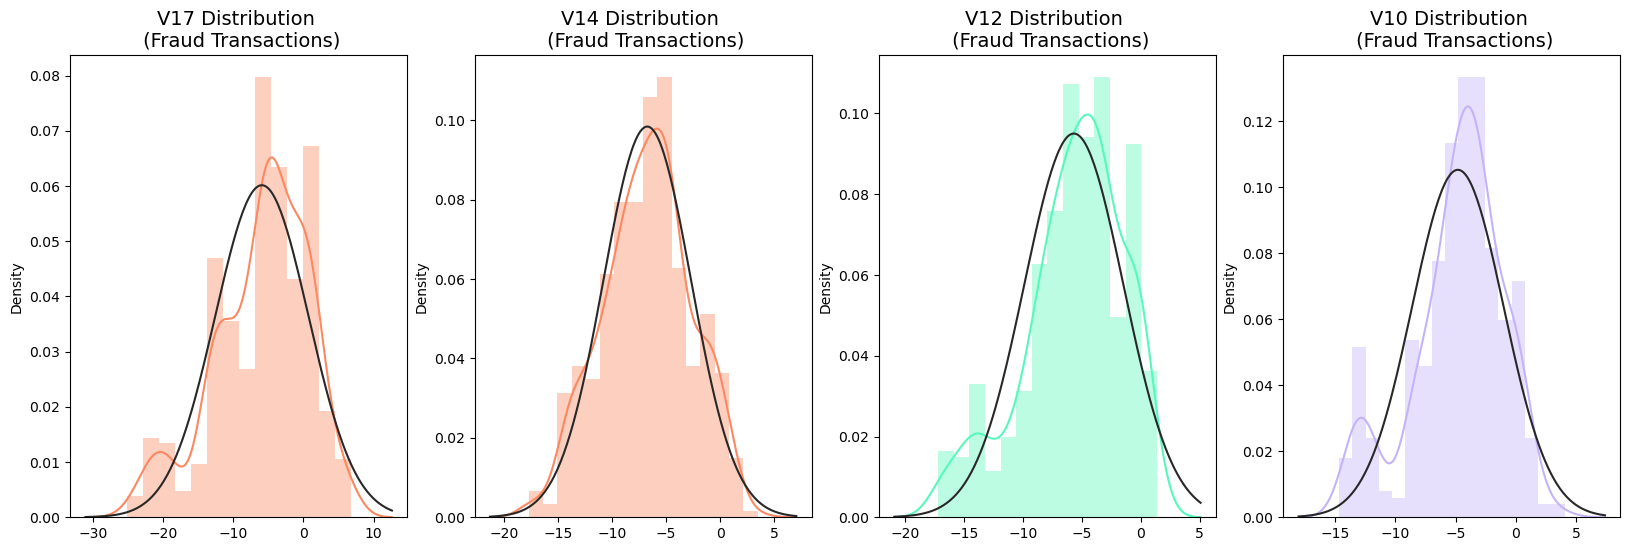

In [22]:
from scipy.stats import norm

f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(20, 6))

v17_fraud_dist = new_df['V17'].loc[new_df['Class'] == 1].values
sns.distplot(v17_fraud_dist,ax=ax0, fit=norm, color='#FB8861')
ax0.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

# outlier remove in random under sampling data 

In [23]:
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.40542306160986 | Quartile 75: -4.28925378244217
iqr: 5.116169279167689
Cut Off: 7.674253918751534
V14 Lower: -17.07967698036139
V14 Upper: 3.3850001363093636
Feature V14 Outliers for Fraud Cases: 5
V10 outliers:[-17.230202160711, 3.44242199594215, -17.6206343516773, -17.4759212828566, -17.7216383537133]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -15.42820164591653
V12 Upper: 4.81480448146737
V12 outliers: [-17.003289445516, -16.218610393127, -15.4790524832016, -17.003289445516, -15.5316111795156, -15.5316111795156, -17.1504052507291, -15.8357188077344, -17.1829184301947, -15.7176066468772, -17.1829184301947, -15.969207520809]
Feature V12 Outliers for Fraud Cases: 12
Number of Instances after outliers removal: 930
--------------------------------------------------------------------------------------------------------------------

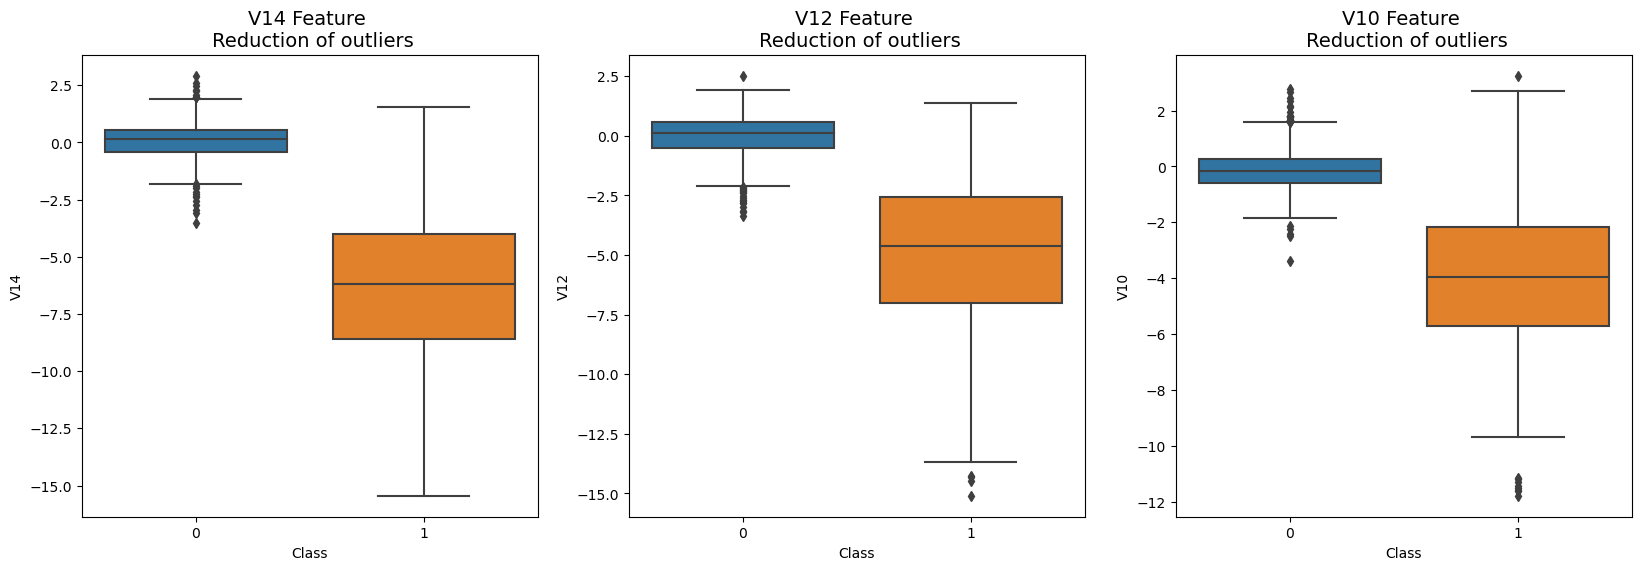

In [24]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)

plt.show()

In [25]:
print('outlier removed :', new_df.shape)
print('origin new df :' ,new_df_copy.shape)

outlier removed : (900, 31)
origin new df : (984, 31)


In [26]:
X_train, X_test, y_train, y_test = get_X_y_data(new_df)

lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb,  X_train, X_test, y_train, y_test)

정확도 : 0.92, 정밀도 : 0.98, 재현율 : 0.85
f1-score : 0.91, auc : 0.92
정확도 : 0.94, 정밀도 : 0.97, 재현율 : 0.89
f1-score : 0.93, auc : 0.93


In [27]:
X_train, X_test, y_train, y_test = get_X_y_data(new_df_copy)

lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb,  X_train, X_test, y_train, y_test)

정확도 : 0.93, 정밀도 : 0.99, 재현율 : 0.88
f1-score : 0.93, auc : 0.93
정확도 : 0.93, 정밀도 : 0.99, 재현율 : 0.86
f1-score : 0.92, auc : 0.93


# Dimensionality Reduction and Clustering


In [28]:
# New_df is from the random undersample data (fewer instances)
'''Time과 Amount에 대해서 scailing(normalize)하지 않은 데이터로 하면 효과가 없었음'''
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=20).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=20).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=20).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.4 s
PCA took 0.017 s
Truncated SVD took 0.02 s


In [29]:
new_df.shape

(900, 31)

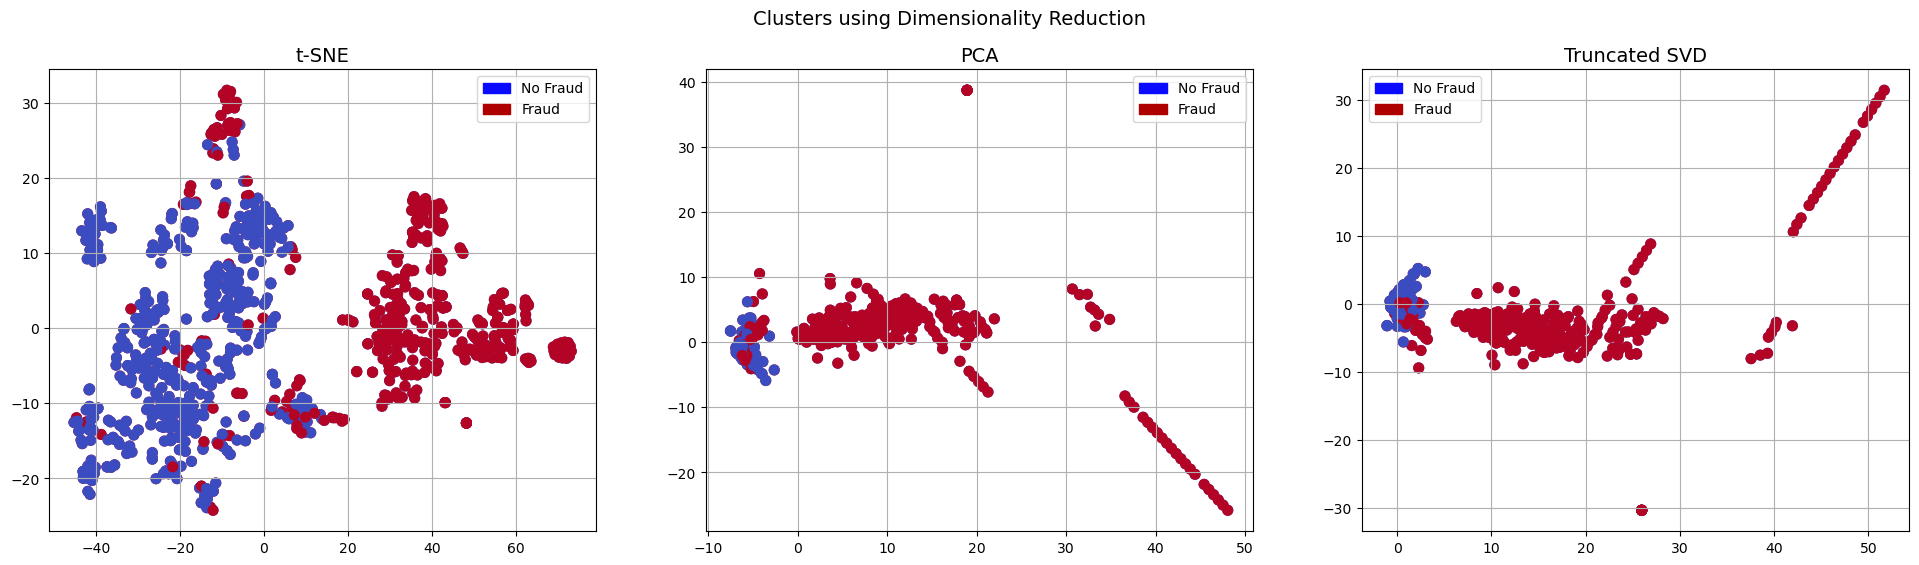

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# compare classifier models 

In [31]:
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
107700,-0.305736,-0.165944,1.279572,0.273420,0.429068,0.910150,-0.152134,-0.286731,-0.102552,-0.053086,...,-0.113904,-0.249759,-0.708377,0.012924,-0.504844,0.412629,-0.570381,0.037018,0.025284,0
256302,-0.279746,0.856906,-0.587100,1.442580,-0.661172,-0.795153,0.735726,-0.570864,0.773890,0.131934,...,0.346346,-0.377375,-0.804947,0.160077,0.567152,-0.351661,0.109458,0.536111,0.252903,0
77348,-0.307273,-0.325251,-1.271244,2.462675,-2.851395,2.324480,-1.372245,-0.948196,-3.065234,1.166927,...,0.560478,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.632800,0.250187,1
42549,0.925452,-0.511578,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,...,1.150017,2.331466,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,1
172787,1.713407,0.429352,-2.628922,2.275636,-3.745369,1.226948,-1.132966,-1.256353,-1.752420,0.281736,...,0.133106,0.870730,1.269473,-0.265494,-0.480549,0.169665,0.096081,0.070036,0.063768,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261699,-0.220918,0.886430,-0.927962,0.986459,1.355748,-0.724227,0.135613,0.574275,0.009833,0.710440,...,-0.101884,-0.147990,-0.537033,-0.338500,-1.136174,0.413005,-0.363986,-0.051853,-0.008217,0
248971,-0.296793,0.816375,-0.549615,2.219075,-3.522024,0.236995,1.087469,-1.235530,-0.279313,0.514361,...,0.126518,0.364130,0.210428,-0.366019,0.015803,0.349212,0.647302,0.171929,0.117188,1
141257,-0.307413,-0.005733,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,...,1.129532,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,1
100623,7.364773,-0.201142,-0.758469,-0.045410,-0.168438,-1.313275,-1.901763,0.739433,3.071892,-0.483422,...,-0.032500,0.042619,0.397224,0.072229,-0.242276,0.560916,-0.540955,0.150606,-0.117140,1


In [32]:
X_train, X_test, y_train, y_test = get_X_y_data(new_df)

'''to array'''
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


X_train

array([[-2.79745686e-01, -3.85342873e-02, -9.36201047e-01, ...,
        -1.53184864e-01, -1.23215245e-01, -1.05653586e-01],
       [ 4.17801998e-02, -4.26356043e-01,  1.28529159e+00, ...,
         1.87929823e-03,  1.22473590e-02,  7.83368473e-03],
       [ 1.25620066e-01, -5.86085363e-01, -6.67308507e-01, ...,
         6.60992695e-01, -4.32223838e-02,  8.62515557e-02],
       ...,
       [-2.97910990e-01, -6.48104419e-01,  1.10280433e+00, ...,
         5.16326674e-01,  9.14628141e-03,  1.53317636e-01],
       [ 6.97268218e-02, -8.41527744e-02, -7.31630770e-01, ...,
         4.82931671e-01, -7.87489005e-02,  1.82053028e-02],
       [-2.79466220e-01,  5.74489832e-03, -3.00345942e+00, ...,
        -5.95547733e-02,  4.60709677e-01, -3.35506071e-02]])

In [33]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [34]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


In [35]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [36]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  93.33%
Knears Neighbors Cross Validation Score 92.74%
Support Vector Classifier Cross Validation Score 93.04%
DecisionTree Classifier Cross Validation Score 90.67%


In [39]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [44]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     print(train_sizes,train_scores,test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/johongcheol/miniforge3/envs/ml_study_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

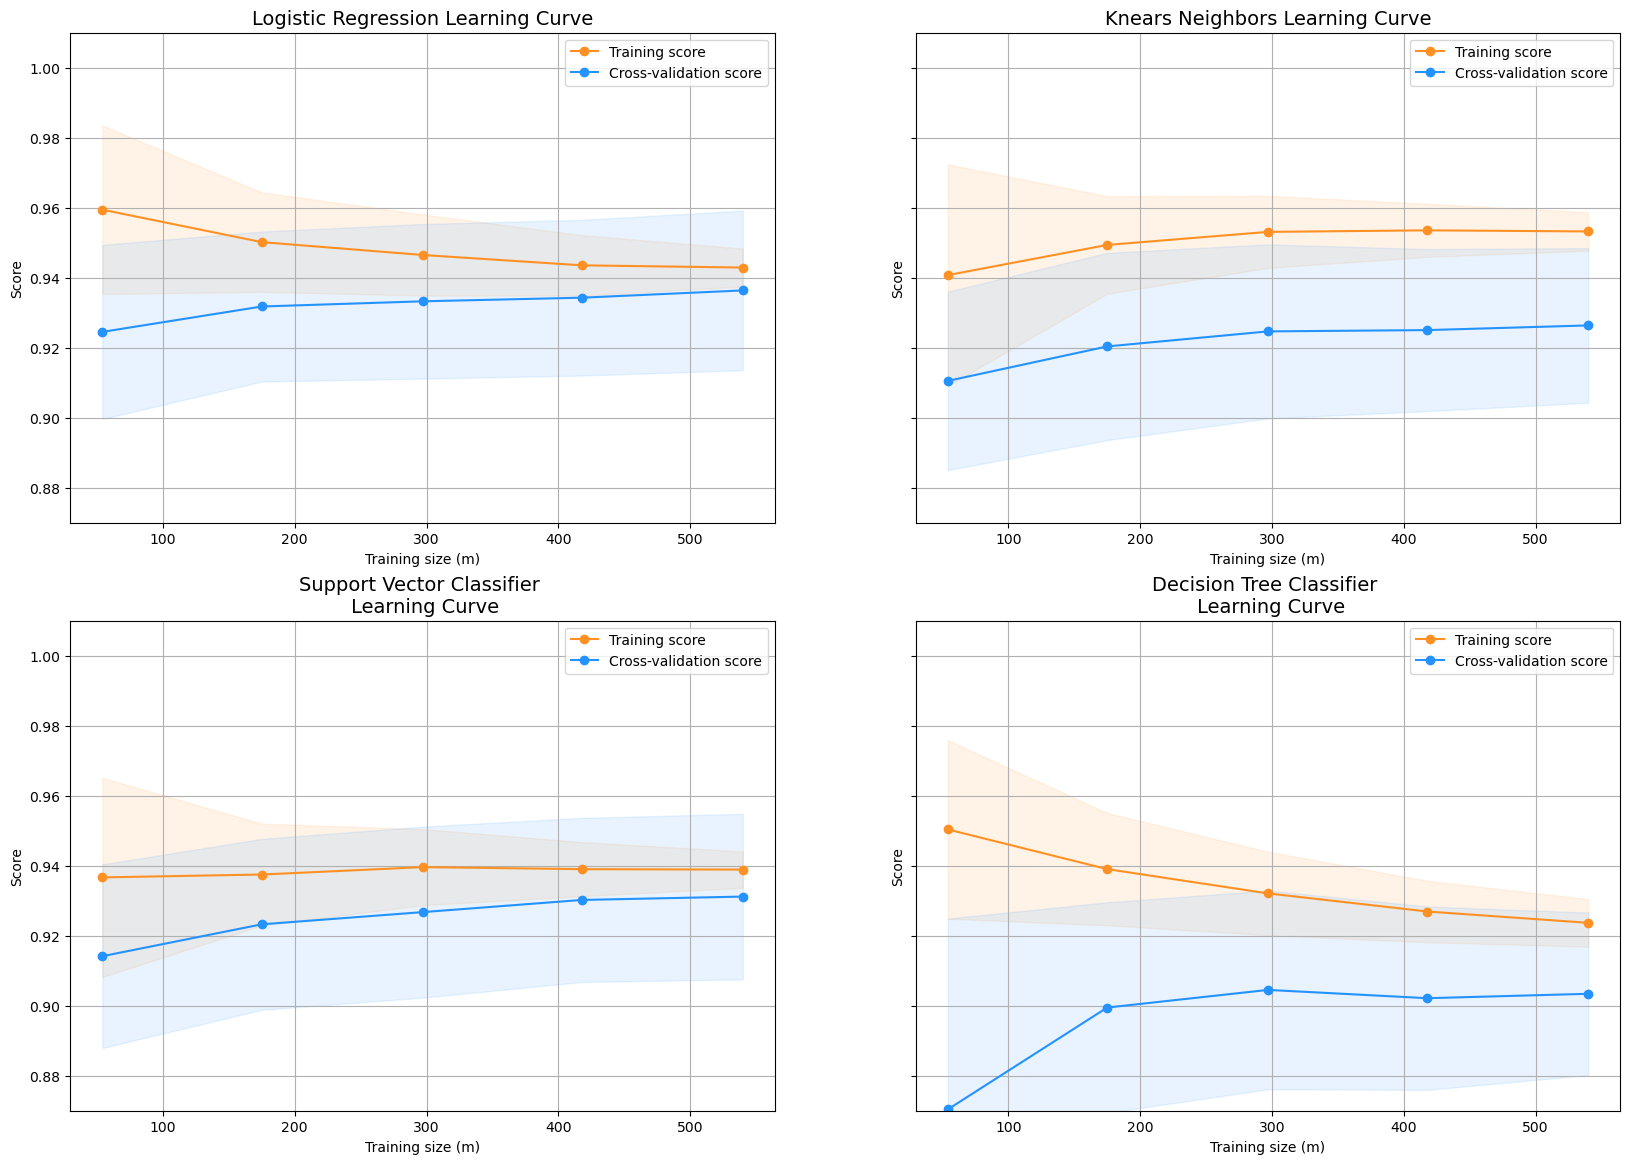

In [45]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [71]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [72]:
log_reg_pred.shape

(675,)

In [73]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9803084160079226
KNears Neighbors:  0.9239880099740039
Support Vector Classifier:  0.9782835517357242
Decision Tree Classifier:  0.9033503103612924


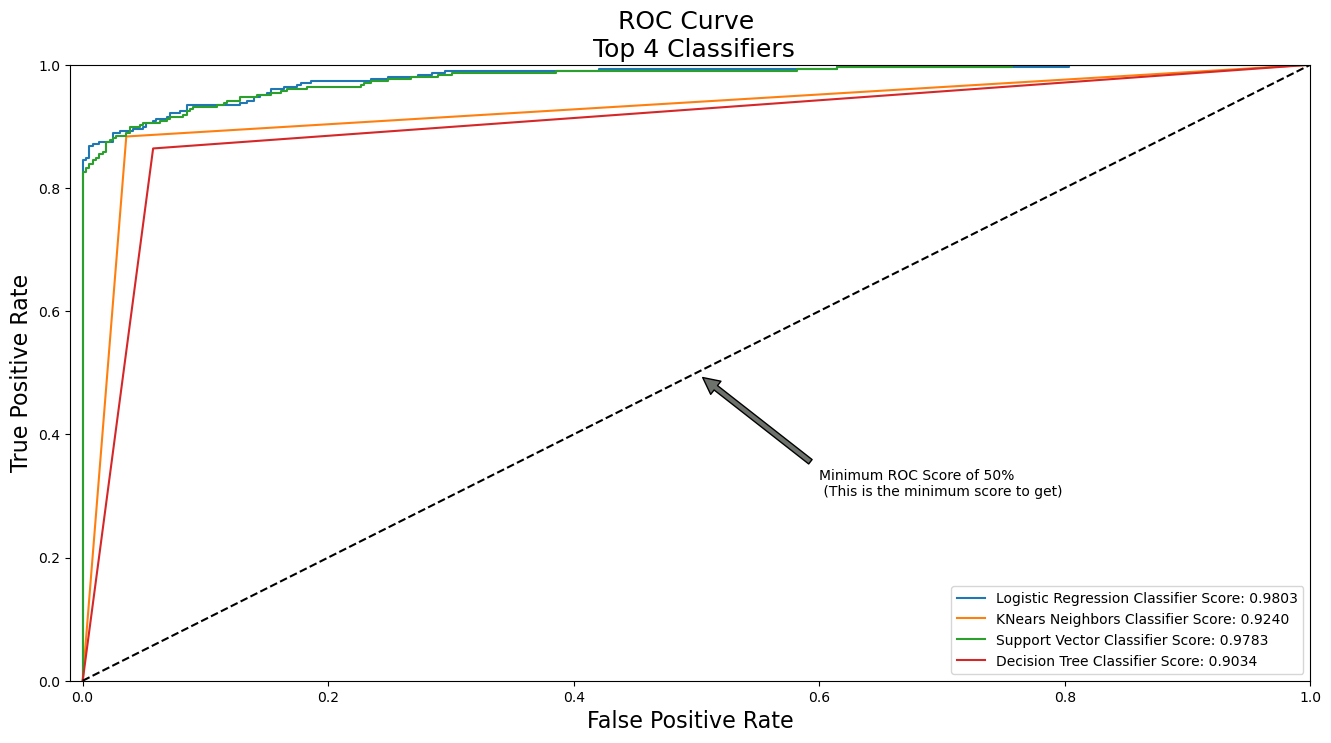

In [74]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

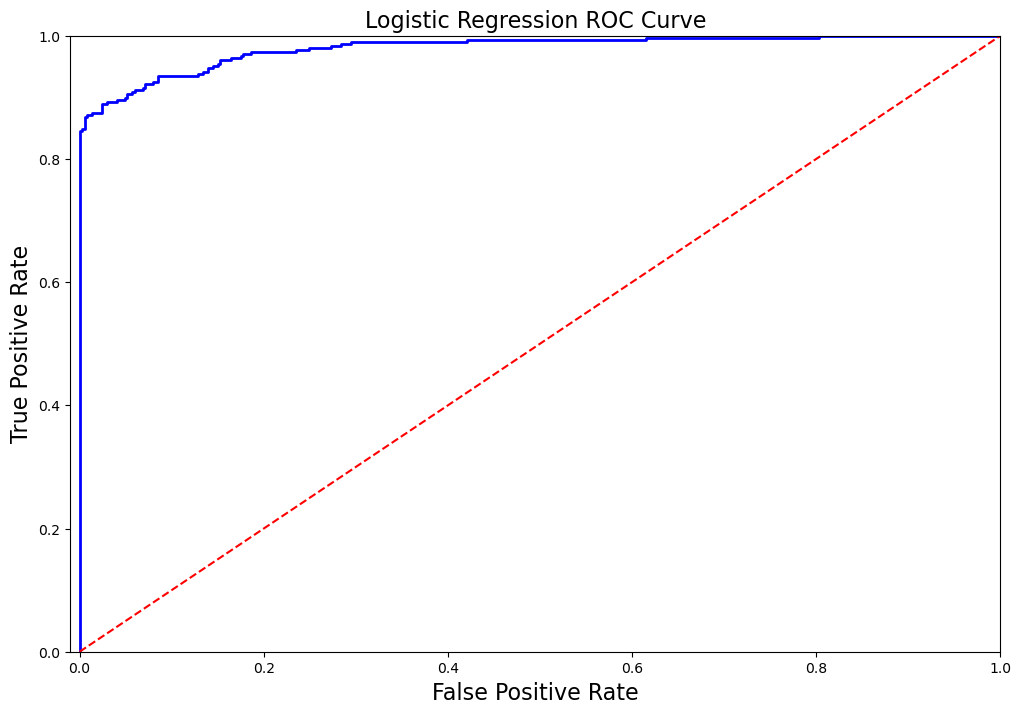

In [75]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [83]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9402849134590971
precision: 0.05925935686288131
recall: 0.9137293086660175
f1: 0.10962067455199279
---------------------------------------------------------------------------------------------------------------------------------------


In [84]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.10      0.86      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961



In [94]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [105]:
Xsm_train.shape, ysm_train.shape

((454904, 30), (454904,))

In [113]:
unique, counts = np.unique(ysm_train, return_counts=True)
unique, counts

(array([0, 1]), array([227452, 227452]))

In [114]:
unique, counts = np.unique(original_ytrain, return_counts=True)
unique, counts

(array([0, 1]), array([227452,    394]))

In [95]:
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :2.0323290824890137 sec


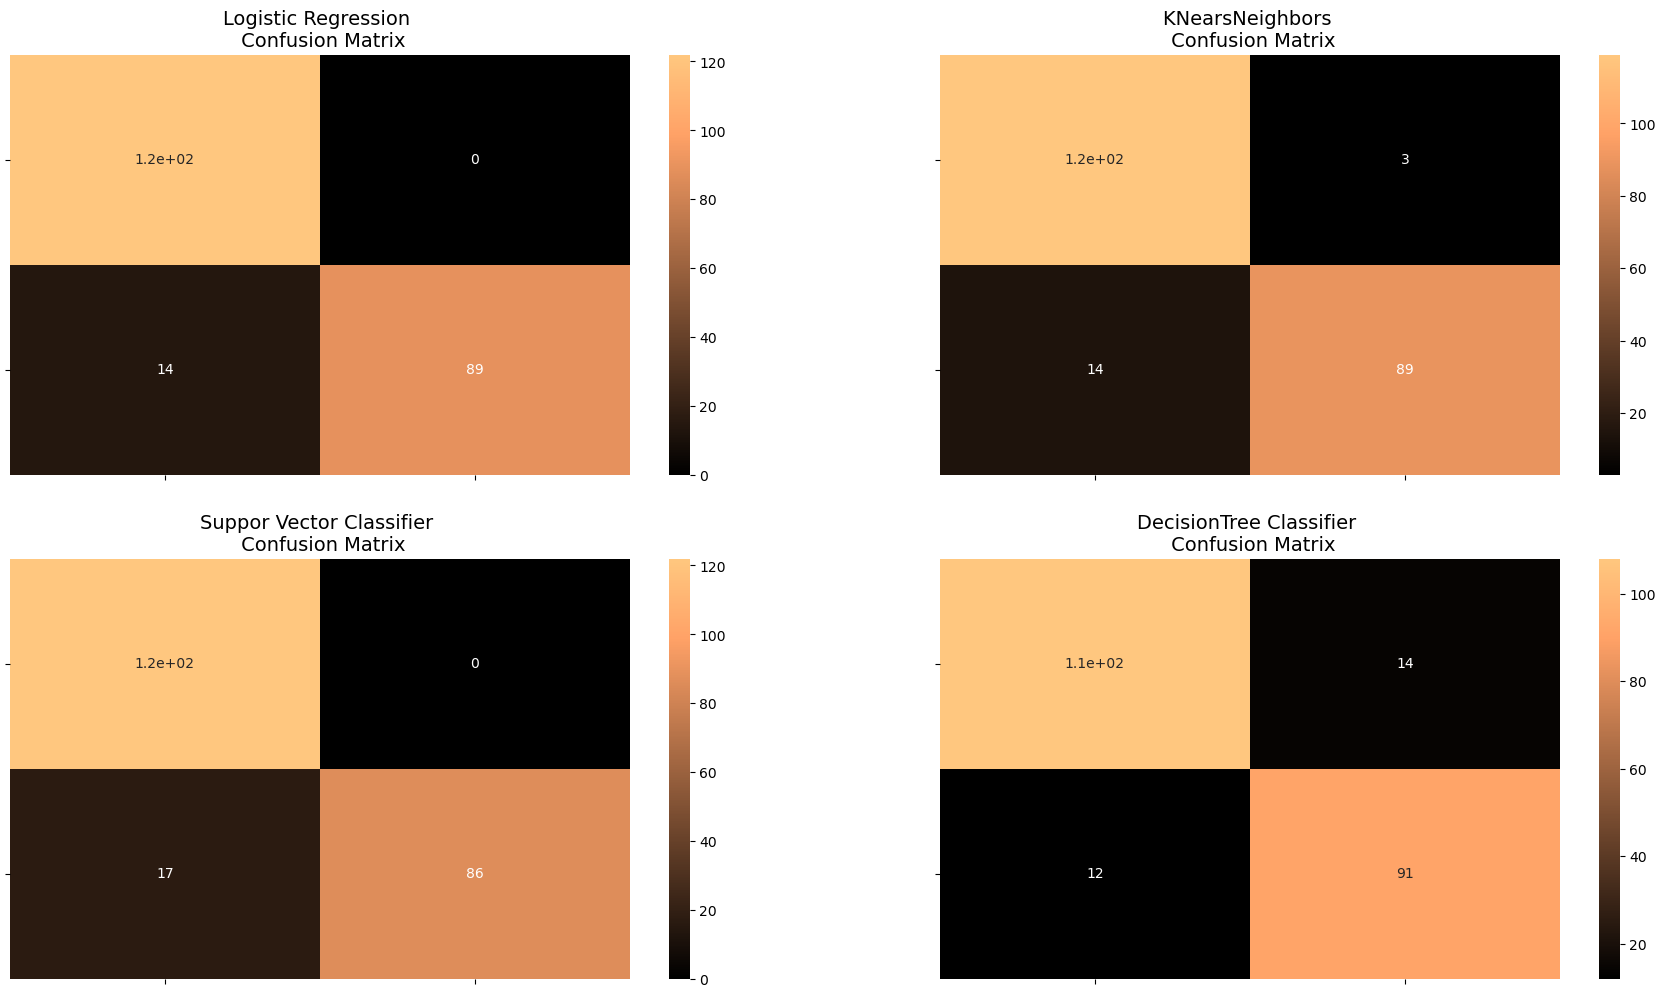

In [100]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = best_est.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [97]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.933333
1,Oversampling (SMOTE),0.985710


# Neural Networks Under Sampling

In [103]:
X_train.shape

(675, 30)

In [101]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Metal device set to: Apple M1 Pro


In [102]:
undersample_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [115]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20


2023-05-15 16:09:14.847471: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 - 2s - loss: 0.6465 - accuracy: 0.5315 - val_loss: 0.4563 - val_accuracy: 0.7778 - 2s/epoch - 68ms/step
Epoch 2/20
22/22 - 0s - loss: 0.3967 - accuracy: 0.8500 - val_loss: 0.3159 - val_accuracy: 0.9259 - 136ms/epoch - 6ms/step
Epoch 3/20
22/22 - 0s - loss: 0.2876 - accuracy: 0.9296 - val_loss: 0.2472 - val_accuracy: 0.9333 - 140ms/epoch - 6ms/step
Epoch 4/20
22/22 - 0s - loss: 0.2338 - accuracy: 0.9315 - val_loss: 0.2032 - val_accuracy: 0.9259 - 132ms/epoch - 6ms/step
Epoch 5/20
22/22 - 0s - loss: 0.1947 - accuracy: 0.9389 - val_loss: 0.1751 - val_accuracy: 0.9259 - 135ms/epoch - 6ms/step
Epoch 6/20
22/22 - 0s - loss: 0.1699 - accuracy: 0.9407 - val_loss: 0.1579 - val_accuracy: 0.9259 - 143ms/epoch - 6ms/step
Epoch 7/20
22/22 - 0s - loss: 0.1532 - accuracy: 0.9444 - val_loss: 0.1462 - val_accuracy: 0.9259 - 137ms/epoch - 6ms/step
Epoch 8/20
22/22 - 0s - loss: 0.1393 - accuracy: 0.9537 - val_loss: 0.1391 - val_accuracy: 0.9259 - 137ms/epoch - 6ms/step
Epoch 9/20
22/22 - 0s - loss:

In [121]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [122]:
undersample_fraud_predictions = undersample_predictions.argmax(axis=-1)
undersample_fraud_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [123]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55431  1432]
 [    7    91]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


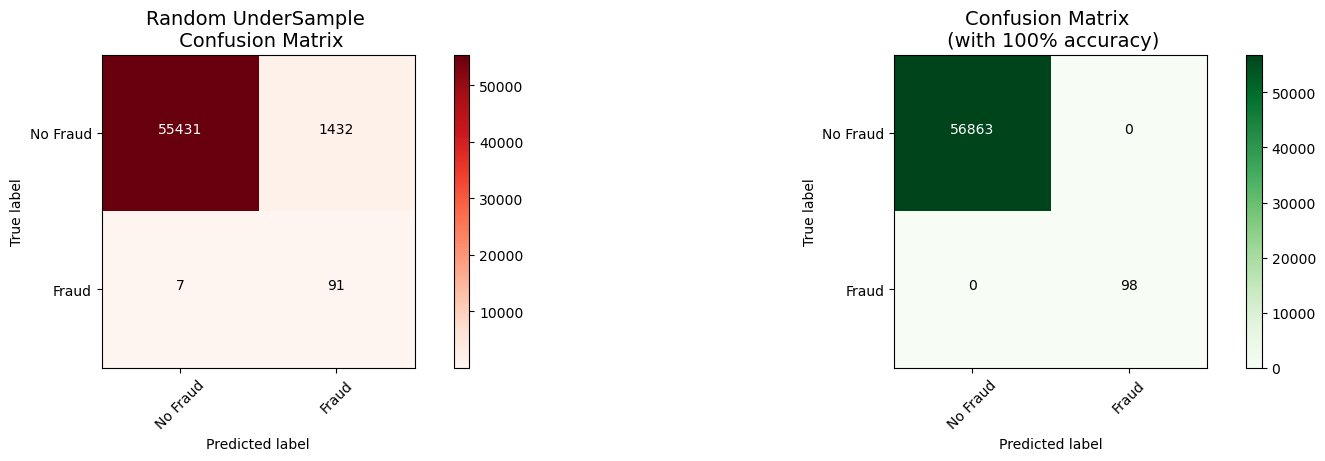

In [124]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [125]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [126]:
oversample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 32)                992       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [127]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [128]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 7s - loss: 0.0820 - accuracy: 0.9740 - val_loss: 0.0221 - val_accuracy: 0.9955 - 7s/epoch - 6ms/step
Epoch 2/20
1214/1214 - 7s - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0116 - val_accuracy: 0.9992 - 7s/epoch - 5ms/step
Epoch 3/20
1214/1214 - 7s - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0042 - val_accuracy: 1.0000 - 7s/epoch - 5ms/step
Epoch 4/20
1214/1214 - 7s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 1.0000 - 7s/epoch - 5ms/step
Epoch 5/20
1214/1214 - 7s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 1.0000 - 7s/epoch - 6ms/step
Epoch 6/20
1214/1214 - 7s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9999 - 7s/epoch - 6ms/step
Epoch 7/20
1214/1214 - 7s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 1.0000 - 7s/epoch - 5ms/step
Epoch 8/20
1214/1214 - 7s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 9.4994e-04 - val_accuracy: 1.0000 - 7s/epoch - 5ms/step
Epoc

In [129]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [131]:
oversample_fraud_predictions = oversample_predictions.argmax(axis=-1)
undersample_fraud_predictions

array([1, 1, 1, ..., 0, 0, 0])

Confusion matrix, without normalization
[[56843    20]
 [   27    71]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


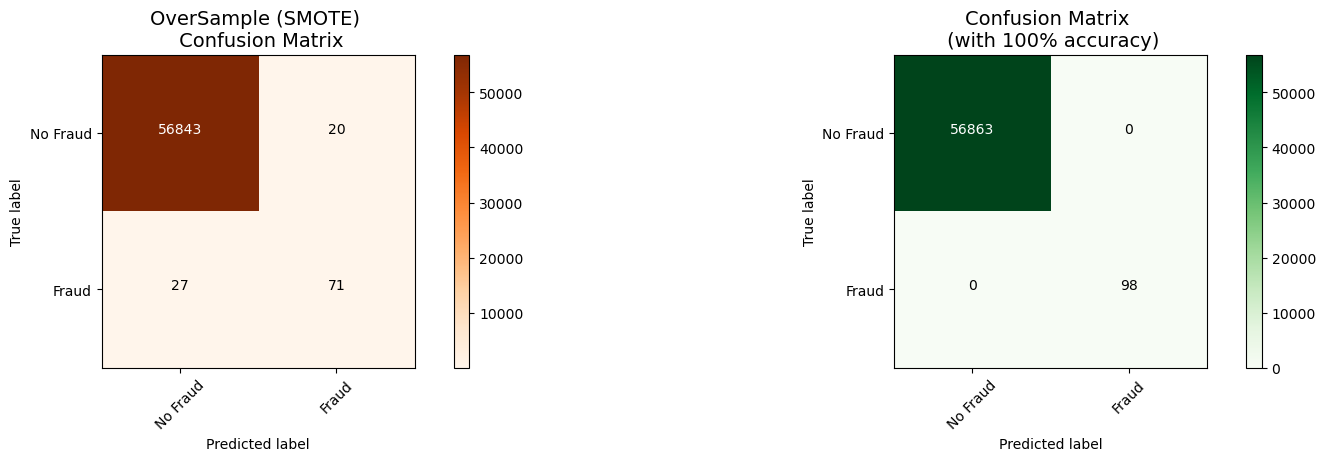

In [132]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)